# Тестирование гипотез: параметрическое тестирование и симуляции

Появляется тогда, когда у вас есть ислледовательский вопрос, например какова эффективность чего-то? А отличается ли мозговая активность мужчин от женщин в состоянии покоя? А влияют ли гормоны на принятие решений?  Исследование организовано так, чтобы можно было собрать данные, а потом уметь сделать выводы. 
## Гипотеза 
Некоторое утверждение про наблюдаемое явление, которое можно либо опровергнуть либо подтвердить. Может быть крупная исследовательская тематика: гормоны и поведение например. А при проведении каждого конкретного эксперимента тестируется вполне кокретная гипотеза. Читаем главу про тестирование гипотез (в ридингах)

Теоретический бэкграунд
 - Bishop Pattern Recognition Chapter 1.2 , Chapter 2
 - Конспект от Yandex ML (coursera) урок 3. Проверка гипотез



## Тестирование гипотез

Для тестирования гипотезы она должна быть


***Обычно***
 - H0(неинтересный вывод, гипотеза, которую хотелось бы отвергнуть)
 - H1 (как раз исследовательская гипотеза)  


***Pipeline*** для проверки гипотезы:
 - Формулируем гипотезу, с помощью которой можно оценить адекватность получить имеющиеся данные 
 - Нам нужна какая-то тестовая статистика - то есть !ОДНО! число (а потом мы должны либо что-то знать про распределение этой тестовой статистики и использовать параметрические подходы например, или уметь получить распределение с помощью либо бутстрепа либо перемешивания), которое мы можем оценить и из исходных данных и из симуляций. Она должна дать базис для сравнения двух гипотез. 
 - Считаем p-value для этой статистики. P-value  - это вероятность получения такого же или большего значения вашей тестовой статистики как в наблюдаемых данных, при условии что нулевая гипотеза верна. !!! НЕ вероятность того, что нулевая гипотеза верна
 
 
 Очень хорошо изученная область статистики, много сложных названий и тестов.
 Задача на сегодня: получить интуицию про тестовую статистику,  p-value  и уровень значимости

###  Сравнение средних: постановки задач

!!! Привести примеры из жизни
```
- H0: среднее равно какому-то конкретному значению (например нулю)
- H1: среднее не равно (больше, меньше)
```


```
 - H0: даны две группы, средние в группах равны
 - H1: среднее не равно (больше, меньше)
```
"""

### Параметрические методы
#### z интервал
 $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$
 
#### t interval
Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

#### Важные предположения

 - Дисперсии выборок равны (часто нарушается)
 - Обе группы получились из одного распределения
 
#### На выходе
 Получаем ответ только про среднее значение. Можем хотеть знать про медиану, дисперсию, вообще проверять идентичность распределения.
 Что для этого нужно? Почему это сложно в рамках параметрических подходов
 
## Тестирование с помощью симуляций:
### permutation 

Идея заключается в следующем  - соберем все данные в один массив, перемешаем его и нарежем на куски таких же размеров  как у исходных данных. Сделаем так много-много раз. Посчитаем характеристики перемешанных образцов  - и если мы их не можем отличить от исходных характеристик массивов, значит можно считать, что и наши эмпирические данные могут быть одним из таких вариантов перестановок. Можно считать любые характеристики: среднее, медиану, размах, дисперсию, делать вывод о равенстве распределений

### Bootstrap
Ну а допустим у вас нет двух выборок, есть только одна и хотите проверить гипотезу о равенстве среднего конкретному значению (чаще всего 0, есть эффект или нет). Или построить доверительный интервал для среднего, или другой характеристики, или для коэффициента линейной регрессии.
Ну тогда делаем подвыборки того же размера из исходной, а дальше считаем те же самые статистики.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
sns.set(style="whitegrid")
import pingouin as pg
import warnings
import os
warnings.filterwarnings("ignore")
%matplotlib inline
np.set_printoptions(precision=3)

In [7]:
def generate_norm_groups(means = [2,5], sigmas = [1,1], sizes = [20, 40]):
    """
    Artificial data for group comparing testing, sampled from normal distribution 
    
    Args:
        means (list of floats): list of predefined means, length equal to number of groups
        sigmas (list of floats): list of predefined sigmas, length equal to number of groups
        sizes (list of floats): sizes of groups
    
    Return: 
        data(DataFrame): data frame with the data
    
    """
    data = np.concatenate([ sts.norm.rvs(loc = loc, scale = scale, size = size) for loc,scale,size in zip(means,sigmas,sizes)])
 
    groups = np.concatenate([[f'group{i}']*sizes[i] for i in range(len(means))])
    df = pd.DataFrame(dict(value = data, group = groups))
    df['group_id'] = pd.Categorical(df['group']).codes
    return df

In [11]:
groups = generate_norm_groups(means = [2,5], sizes = [40, 50])
groups.head()

,value,group,group_id
0,1.385685,group0,0
1,0.094429,group0,0
2,2.733530,group0,0
3,1.021385,group0,0
4,2.658780,group0,0


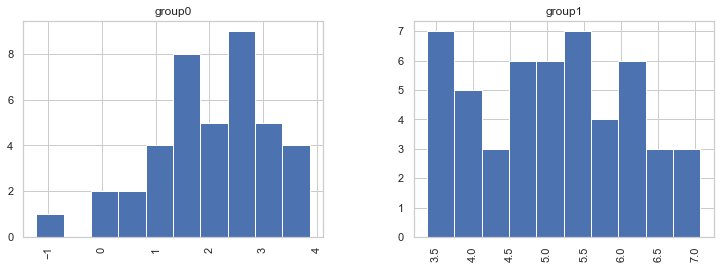

In [12]:
groups.hist('value', by='group', figsize=(12, 4));

<AxesSubplot:xlabel='group', ylabel='value'>

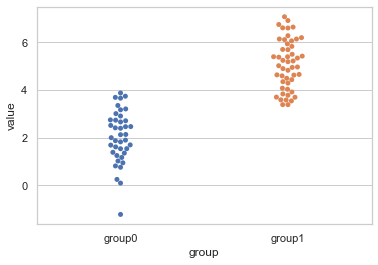

In [13]:
sns.swarmplot(x = 'group', y = 'value', data = groups)


**Односторонний t-тест**

В этом варианте мы предполагаем, что есть какое-то направление 
 - H0: $\mu_p = \mu_r \Rightarrow \mu_p - \mu_r =0 $
 - H1: $\mu_p <\mu_r$

**Двусторонний t-тест**

В этом случае, мы не знаем в какую сторону может отличаться значение, может быть как больше так и меньше
 - H0: $\mu_p = \mu_r$
 - H1: $\mu_p !=\mu_r$

In [21]:
#help(pg.ttest)

In [18]:
pg.ttest(x=groups[groups['group_id']==0].value, y=groups[groups['group_id']==1].value, tail ='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-13.42,81.74,two-sided,0.0,"[-3.49, -2.59]",2.86,4.731e+19,1.0


In [19]:
pg.ttest(x=groups[groups['group_id']==0].value, y=groups[groups['group_id']==1].value, tail ='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-13.42,81.74,less,0.0,"[-inf, -2.66]",2.86,9.463e+19,1.0


Как читать эту табличку? Почему разные интервалы получились?

### Задание:
 - Поэкспериментируйте с размерами выборок и разницей между средними.  Возьмите маленькую разницу и большую дисперсию, маленькую разницу и маленькую дисперсию. При фиксированных параметрах среднего и дисперсии, посмотрите как  p-value  меняется от размера выборки (суммарного по обеим группам). Нарисуйте графики.

 - Теперь добавьте различия в дисперсии у двух групп. Как меняется p-value?
 


## Перемешивание 
Очень простая и мощная идея для проверки гипотез, раньше не использовалась только потому-что не было вычислительных возможностей, но были толстые книжки с цифрами, сейчас почти всю проверку гипотез можно делать перемешиванием и забыть про названия (но лучше помнить, вы так будете казаться солидней) 
Идея (проще не придумаешь): у нас есть две группы, мы хотим понять что-то про их одинаковость. У каждой группы у нас есть индикатор группы. Давайте перемешаем все индикаторы групп и заново переразделим. Будем смотреть каким получается значение интересующей нас статистики у новых групп


Еще раз  - соберем все данные в один массив, перемешаем его и нарежем на куски таких же размеров  как у исходных данных. Сделаем так много-много раз. Посчитаем характеристики перемешанных образцов  - и если мы их не можем отличить от исходных характеристик массивов, значит можно считать, что и наши эмпирические данные могут быть одним из таких вариантов перестановок.

In [22]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    data = np.concatenate((data1, data2))

    permuted_data = np.random.permutation(data)

    return permuted_data[:len(data1)], permuted_data[len(data1):]

In [41]:
data1 = groups[groups['group_id']==0].value
data2 = groups[groups['group_id']==1].value
permutation_sample(data1, data2)

(array([5.374, 4.074, 2.46 , 3.383, 3.694, 1.169, 6.058, 0.814, 3.914,
        1.021, 4.03 , 3.348, 5.698, 5.495, 3.54 , 3.872, 5.183, 1.534,
        6.134, 4.651, 5.418, 6.91 , 4.633, 5.392, 5.933, 2.464, 3.832,
        5.241, 4.346, 5.827, 6.274, 4.49 , 4.945, 2.393, 3.655, 1.351,
        0.758, 6.11 , 6.596, 1.695]),
 array([ 4.824,  5.392,  3.383,  2.133,  1.823,  3.579,  3.204,  4.591,
         5.015,  1.386,  5.689,  0.945,  1.611,  3.7  ,  1.537,  2.708,
         4.431,  3.168,  2.744,  1.687,  6.744,  6.636,  6.193,  6.604,
         2.411,  1.25 ,  3.688,  4.287,  5.216,  7.069,  2.659,  4.622,
         4.963,  0.094,  3.778,  0.249,  2.906,  3.007, -1.219,  6.135,
         2.734,  1.872,  2.124,  2.513,  4.895,  3.586,  1.895,  3.737,
         5.336,  1.998]))

In [45]:
print(f'Real mean for data1: {np.mean(data1):.2f}, for data2 : {np.mean(data2):.2f}')
print(f'Means for permuted samples: {[np.mean(el) for el in permutation_sample(data1, data2)]}')

Real mean for data1: 2.03, for data2 : 5.08
Means for permuted samples: [3.6365872850744934, 3.795433053766932]


In [47]:
list(map(np.mean,permutation_sample(data1, data2)))

[3.9646352927086412, 3.532994647659613]

In [53]:
np.diff(list(map(np.mean,permutation_sample(data1, data2))))

array([-0.027])

In [48]:
print('Видно что средние значения переразбитых выборок сильно отличаются')
[list(map(np.mean,permutation_sample(data1, data2))) for i in range(5)]

Видно что средние значения переразбитых выборок сильно отличаются


[[4.109175510856114, 3.4173624731416345],
 [3.4203683449019096, 3.9684082059049985],
 [3.706748928190798, 3.739303739273888],
 [3.6489767944575804, 3.7855214462604625],
 [3.6829141344611216, 3.75837157425763]]

In [51]:
t_diff = np.mean(data2) -np.mean(data1)
print(f'Тестовая статистика {t_diff:.2f} и мы проверяем гипотезу о равенстве ее нулю')

Тестовая статистика 3.04 и мы проверяем гипотезу о равенстве ее нулю


In [52]:
p1, p2 = permutation_sample(data1, data2)
np.mean(p2) - np.mean(p1)

-0.5571263343901327

In [73]:
def diff_of_means(data1, data2, nsamples, plot = True):
    """Difference in means of two arrays."""

    t_diff = np.mean(data2) - np.mean(data1)
    diffs = np.squeeze(np.diff([list(map(np.mean,permutation_sample(data1, data2))) for i in range(nsamples)]))
    p_val = np.mean(diff>t_diff)  
    alpha = np.percentile(diff, 95)
    print(f'Real level {t_diff},p_val: {p_val}, level enough to reject at alpha 95% is {alpha :.2f}')
    if plot:
        val = plt.hist(diff, density = True)
        plt.vlines(t_diff, 0, max(val[0]), 'red',  label = 'Observed stat');
        plt.vlines(np.percentile(diff, 95), 0, max(val[0]), 'black',  label = 'alpha-level 0.95');
        plt.legend()
        
    return diff

Real level 3.0418387636397983,p_val: 0.0, level enough to reject at alpha 95% is 0.65


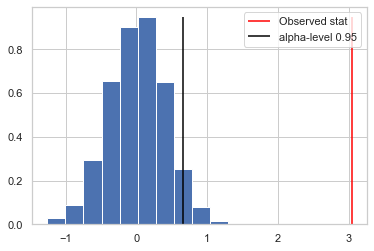

In [74]:
diff = diff_of_means(data1, data2, 1000)

## Проверка равенства дисперсии
точно так же можно проверить и равенство дисперсии и любой другой статистики
Код написан не оптимально, тестируется только односторонняя гипотеза, все это вам нужно будет в скриптах поправить

In [75]:
def diff_of_stds(data1, data2, nsamples, plot = True):
    """Difference in means of two arrays."""

    t_diff = np.std(data2) - np.std(data1)
    diffs = np.squeeze(np.diff([list(map(np.std,permutation_sample(data1, data2))) for i in range(nsamples)]))
    p_val = np.std(diff>t_diff)  
    alpha = np.percentile(diff, 95)
    print(f'Real level {t_diff},p_val: {p_val}, level enough to reject at alpha 95% is {alpha :.2f}')
    if plot:
        val = plt.hist(diff, density = True)
        plt.vlines(t_diff, 0, max(val[0]), 'red',  label = 'Observed stat');
        plt.vlines(np.percentile(diff, 95), 0, max(val[0]), 'black',  label = 'alpha-level 0.95');
        plt.legend()
        
    return diff

Real level -0.05106192437459511,p_val: 0.496141108959941, level enough to reject at alpha 95% is 0.65


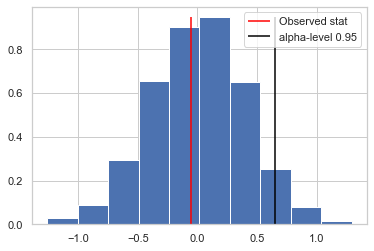

In [76]:
diff_std = diff_of_stds(data1, data2, 1000)

Точно так же можно с помощью перемешивания можно проверять гипотезы о равенстве долей.
Например, посмотрим следующую задачу:
По данным опроса, 75% работников ресторанов утверждают, что испытывают на работе существенный стресс, оказывающий негативное влияние на их личную жизнь. Крупная ресторанная сеть опрашивает 100 своих работников, чтобы выяснить, отличается ли уровень стресса работников в их ресторанах от среднего. 67 из 100 работников отметили высокий уровень стресса. Может ли компания похвастаться, что уровень стресса ее работников ниже среднего по рынку?

In [77]:
overall = np.array(75*[1]+25*[0])
restrt = np.array(50*[1]+50*[0])

In [52]:
np.mean(overall)

0.75

Real level -0.25,p_val: 0.738, level enough to reject at alpha 95% is 0.65


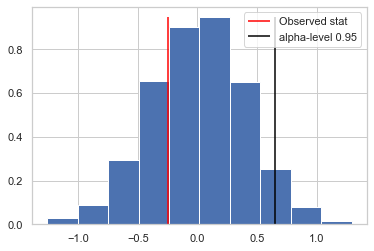

In [78]:
diff = diff_of_means(overall, restrt, 1000)

In [67]:
np.mean(diff>t_diff)

0.0

In [62]:
t_diff = np.mean(overall) - np.mean(restrt)
np.mean(diff>t_diff)

0.0

## Bootstrap

Давайте представим теперь, что у нас есть данные для одних и тех же объектов в разных условиях (повторные измерение). Мы изучаем например как качество сна влияет на скорость реакции. Тестируем группу студентов: даем решать какие-то простые задачки на скорость реакции, а потом отправляем их всей толпой танцевать на всю ночь и с утра снова тестируем. В рамках данного теста гипотеза или принимается на основе полученного доверительного интервала

In [97]:
size = 40
groups = generate_norm_groups(means = [20,10], sizes = [40, 40])
person_id = np.tile(np.arange(size),2)
groups['person_id'] = person_id 
groups.head()

,value,group,group_id,person_id
0,21.056131,group0,0,0
1,20.426656,group0,0,1
2,19.364472,group0,0,2
3,19.208989,group0,0,3
4,20.433119,group0,0,4


In [108]:
rep_groups = pd.pivot_table(groups[['value','group','person_id']], columns = 'group', index='person_id')
rep_groups.columns = ['before','after']
rep_groups.head()

,before,after
person_id,,
0,21.056131,9.676872
1,20.426656,11.277023
2,19.364472,10.898703
3,19.208989,9.168129
4,20.433119,10.980349


In [121]:
# можно сделать в рамках параметрической статистики
pre = rep_groups['before']
post = rep_groups['after']
pg.ttest(pre, post, paired=True, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,44.48,39,greater,0.0,"[9.87, inf]",10.23,6.882e+31,1.0


In [158]:
v_diff = pre-post
np.mean(np.random.choice(v_diff, size=len(v_diff)))

10.684558100826399

In [154]:
def bootstrap_comp_paired(pre,post, nsamples=1000, plot=True):
    diffs = pre-post
    real_diff = np.mean(diffs)
    b_diffs = [np.mean(np.random.choice(diffs, size=len(pre))) for i in range(nsamples)]
    if plot:
        val = plt.hist(b_diffs)
        plt.vlines(np.percentile(b_diffs, 2.5), 0, max(val[0]), 'red',  label = '2.5 alpha level');
        plt.vlines(np.percentile(b_diffs, 97.5), 0, max(val[0]), 'red', label = '97.5 alpha level');
        plt.vlines(np.percentile(b_diffs, 95), 0, max(val[0]), 'black', label = '95 alpha level');
        plt.legend()

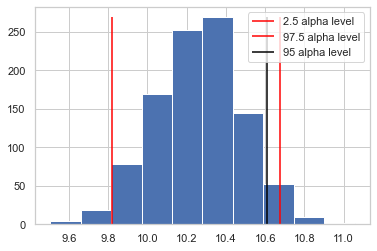

In [155]:
bootstrap_comp_paired(pre,post)

### Оценка коэффициентов линейной регрессии
C помощью бутстрапа можно строить доверительные интервалы для любых наборов данных.
Можно получить оценки коэффициентов линейной регрессии. Как это сделать?

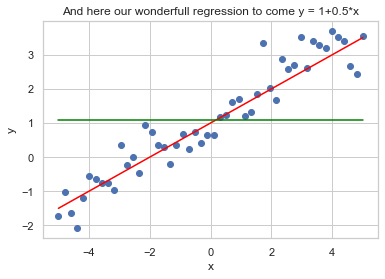

In [159]:
x = np.linspace(-5,5,50)
a = 1
b = 0.5
eps = np.random.randn(50)
y = a + b*x + 0.5*eps
plt.scatter(x,y); plt.plot(x, a+b*x, color = 'red');
plt.plot(x, np.ones(50)*np.mean(y),color = 'green')
plt.title(f'And here our wonderfull regression to come y = {a}+{b}*x');
plt.xlabel('x');
plt.ylabel('y');

In [160]:
print('Linear model with pingouin')
lm = pg.linear_regression(x, y)
print(f'Истинные параметры: intercept:{a},coeff {b}')
print('Видим, что здесь еще выводятся доверительные интервалы, ошибка,\n p-value (тестируется гипотеза о равенстве коэффициента нулю')
lm.round(3)

Linear model with pingouin
Истинные параметры: intercept:1,coeff 0.5
Видим, что здесь еще выводятся доверительные интервалы, ошибка,
 p-value (тестируется гипотеза о равенстве коэффициента нулю


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.097,0.070,15.715,0.0,0.91,0.908,0.957,1.237
1,x1,0.522,0.024,22.024,0.0,0.91,0.908,0.474,0.570


### Задание
получите доверительные интервалы для коэффициентов регрессии (hint - в бутстрапе надо что-то мешать, самое сложное здесь понять что надо мешать)

In [161]:
np.percentile(data1, 95)

3.690743379859476

In [ ]:
lamb